#Face detection using LFW dataset

In [ ]:
#Load data
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.datasets import fetch_lfw_people
from keras.models import Sequential, load_model
from tensorflow.keras.constraints import MaxNorm
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from pathlib import Path
#https://www.kaggle.com/code/georgearnall/yale-face-recognition

In [ ]:
def augment_data(X_train, y_train, batch_size=32, augment_factor=20):
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        zoom_range=0.2,
        channel_shift_range=0.1,
        shear_range=0.2
    )
    datagen.fit(X_train)
    batches = (len(X_train) * augment_factor) // batch_size
    X_aug = []
    y_aug = []
    gen = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
    for _ in range(batches):
        X_batch, y_batch = next(gen)
        X_aug.append(X_batch)
        y_aug.append(y_batch)
    X_aug = np.concatenate(X_aug)
    y_aug = np.concatenate(y_aug)
    print(f"Augmented data shape: {X_aug.shape}, {y_aug.shape}")
    return X_aug, y_aug

def load_lfw_data(test_size=0.2, random_state=42):
    download_folder = Path("../data/external/lfw-dataset")
    lfw_people = fetch_lfw_people(color=True, resize=0.5, funneled=True, download_if_missing=True, data_home=download_folder, min_faces_per_person=20)
    X = lfw_people.images
    y = lfw_people.target

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    return X_train, X_val, y_train, y_val, lfw_people

In [ ]:
class FaceRecognitionModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()
    
    # def build_model(self):
    #     model = Sequential()
    #     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
    #     model.add(BatchNormalization())
    #     model.add(MaxPooling2D(pool_size=(2, 2)))
    #     model.add(Conv2D(64, (3, 3), activation='relu'))
    #     model.add(BatchNormalization())
    #     model.add(MaxPooling2D(pool_size=(2, 2)))
    #     model.add(Conv2D(128, (3, 3), activation='relu'))
    #     model.add(BatchNormalization())
    #     model.add(MaxPooling2D(pool_size=(2, 2)))
    #     model.add(Conv2D(256, (3, 3), activation='relu'))
    #     model.add(BatchNormalization())
    #     model.add(MaxPooling2D(pool_size=(2, 2)))
    #     # Dodana warstwa, bez pooling
    #     model.add(Conv2D(512, (1, 1), activation='relu'))
    #     model.add(BatchNormalization())
    #     model.add(Dropout(0.9))
    #     model.add(Conv2D(1024, (1, 1), activation='relu'))
    #     model.add(BatchNormalization())
    #     model.add(Dropout(0.9))
    #     model.add(Flatten())
    #     model.add(Dense(256, activation='relu'))
    #     model.add(BatchNormalization())
    #     model.add(Dropout(0.95))
    #     model.add(Dense(self.num_classes, activation='softmax'))
    #     return model

    #def build_model(self):
        # model = Sequential()
        # # Block 1
        # model.add(Conv2D(64, (3, 3), activation='relu', input_shape=self.input_shape, padding='same'))
        # model.add(BatchNormalization())
        # model.add(MaxPooling2D(pool_size=(2, 2)))
        # model.add(Dropout(0.25))
        # # Block 2
        # model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        # model.add(BatchNormalization())
        # model.add(MaxPooling2D(pool_size=(2, 2)))
        # model.add(Dropout(0.25))
        # # Block 3
        # model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        # model.add(BatchNormalization())
        # model.add(MaxPooling2D(pool_size=(2, 2)))
        # model.add(Dropout(0.5))
        # # Flatten and Dense layers
        # model.add(Flatten())
        # model.add(Dense(512, activation='relu'))
        # model.add(BatchNormalization())
        # model.add(Dropout(0.5))
        # model.add(Dense(self.num_classes, activation='softmax'))
        # return model
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(64, (3, 3), activation='relu', input_shape=self.input_shape, padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes, activation='softmax'))
        return model


    def compile_model(self, learning_rate=0.0001):
        self.model.compile(optimizer=Adam(learning_rate=learning_rate),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    def train(self, train_data, train_labels, validation_data, validation_labels, epochs=100, batch_size=32):
        history = self.model.fit(train_data, train_labels,
                                 validation_data=(validation_data, validation_labels),
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 verbose=1)
        return history

    def save_model(self, filepath):
        self.model.save(filepath)

    def load_model(self, filepath):
        self.model = load_model(filepath)
        return self.model

In [4]:
def visualize_results(X_test, y_test, y_pred_classes, names_array, num_images=12):
    print(names_array)
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(4, 3, i + 1)
        plt.imshow(X_test[i])
        plt.title(f'True: {names_array[y_test[i]]}, Pred: {names_array[y_pred_classes[i]]}')
        plt.axis('off')
    plt.show()
def visualize_images(images, titles=None):
    import matplotlib.pyplot as plt
    n = len(images)
    plt.figure(figsize=(20, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        img = images[i]
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

def train(X_train, X_test, y_train, y_test, target_names):
    # Create and compile the face recognition model
    model = FaceRecognitionModel(num_classes=len(target_names), input_shape=X_train.shape[1:])
    model.build_model()
    model.compile_model(learning_rate=0.0003)
    print("Starting training...")
    print(f"Number of training samples: {len(X_train)}")
    steps_per_epoch = len(X_train) // 32
    # Train the model
    history = model.model.fit(
        X_train,
        y_train,
        steps_per_epoch=steps_per_epoch,
        epochs=100,
        validation_data=(X_test, y_test),
        batch_size=64,
        verbose=1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    # Save the trained model
    model.save_model("../models/face_recognition_model.keras")

    # show history diagram
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

In [5]:
def evaluate_model(model_path, X_test, y_test):
    model = load_model(model_path)
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred_classes)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    return X_test, y_test, y_pred_classes

Augmented data shape: (48086, 62, 47, 3), (48086,)


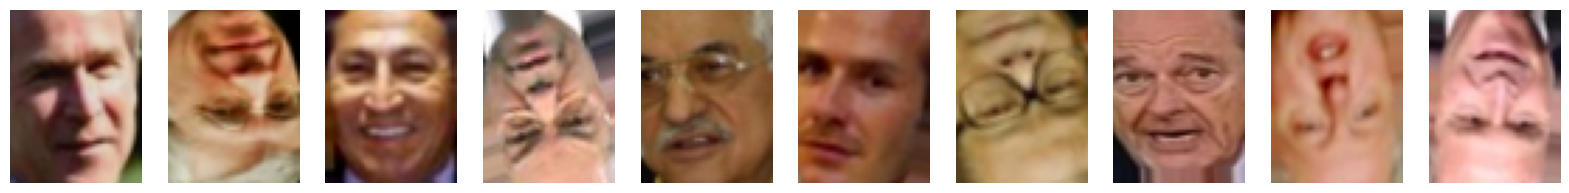

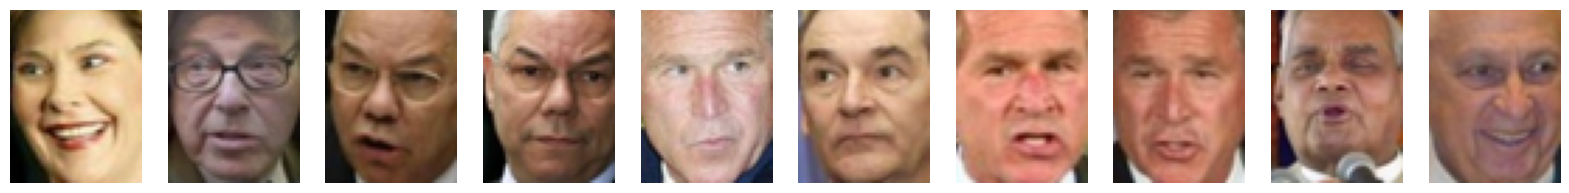

c:\Users\Kamil\WWSI\dev\MachineLearning\ARISA-Final-Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting training...
Number of training samples: 48086
Epoch 1/100
 752/1502 ━━━━━━━━━━━━━━━━━━━━ 2:23 191ms/step - accuracy: 0.0646 - loss: 4.8344

c:\Users\Kamil\WWSI\dev\MachineLearning\ARISA-Final-Project\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1502/1502 ━━━━━━━━━━━━━━━━━━━━ 147s 96ms/step - accuracy: 0.1093 - loss: 4.3767 - val_accuracy: 0.1471 - val_loss: 4.0710
Epoch 2/100
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 152s 101ms/step - accuracy: 0.2769 - loss: 3.1106 - val_accuracy: 0.2562 - val_loss: 3.5475
Epoch 3/100
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 161s 107ms/step - accuracy: 0.4072 - loss: 2.3015 - val_accuracy: 0.4942 - val_loss: 1.9227
Epoch 4/100
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 156s 104ms/step - accuracy: 0.5176 - loss: 1.7845 - val_accuracy: 0.6512 - val_loss: 1.2990
Epoch 5/100
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 153s 102ms/step - accuracy: 0.6110 - loss: 1.3937 - val_accuracy: 0.7058 - val_loss: 1.0773
Epoch 6/100
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 154s 102ms/step - accuracy: 0.6876 - loss: 1.0979 - val_accuracy: 0.7504 - val_loss: 0.9970
Epoch 7/100
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 154s 103ms/step - accuracy: 0.7444 - loss: 0.8660 - val_accuracy: 0.8099 - val_loss: 0.7202
Epoch 8/100
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 156s 104ms/step - accurac

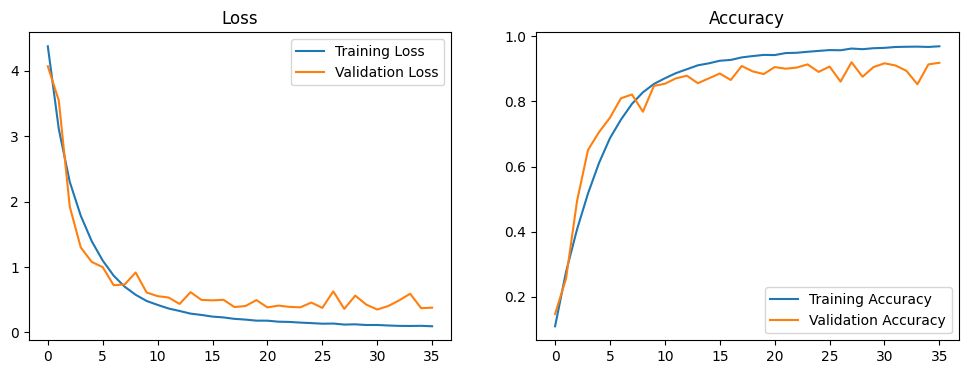

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Accuracy: 91.74%
['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Carlos Menem' 'Colin Powell'
 'David Beckham' 'Donald Rumsfeld' 'George Robertson' 'George W Bush'
 'Gerhard Schroeder' 'Gloria Macapagal Arroyo' 'Gray Davis'
 'Guillermo Coria' 'Hamid Karzai' 'Hans Blix' 'Hugo Chavez' 'Igor Ivanov'
 'Jack Straw' 'Jacques Chirac' 'Jean Chretien' 'Jennifer Aniston'
 'Jennifer Capriati' 'Jennifer Lopez' 'Jeremy Greenstock' 'Jiang Zemin'
 'John Ashcroft' 'John Negroponte' 'Jose Maria Aznar'
 'Juan Carlos Ferrero' 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush'
 'Lindsay Davenport' 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva'
 'Mahmoud Abbas' 'Megawati Sukarnoputri' 'Michael Bloomberg' 'Naomi Watts'
 'Nestor Kirchner' 'Paul Bremer' 'Pete Sampras' 'Recep Tayyip Erdogan'
 'Ricardo Lagos' 'Roh Moo-hyun' 'Rudolph Giuliani' 'Saddam Hussein'
 'Se

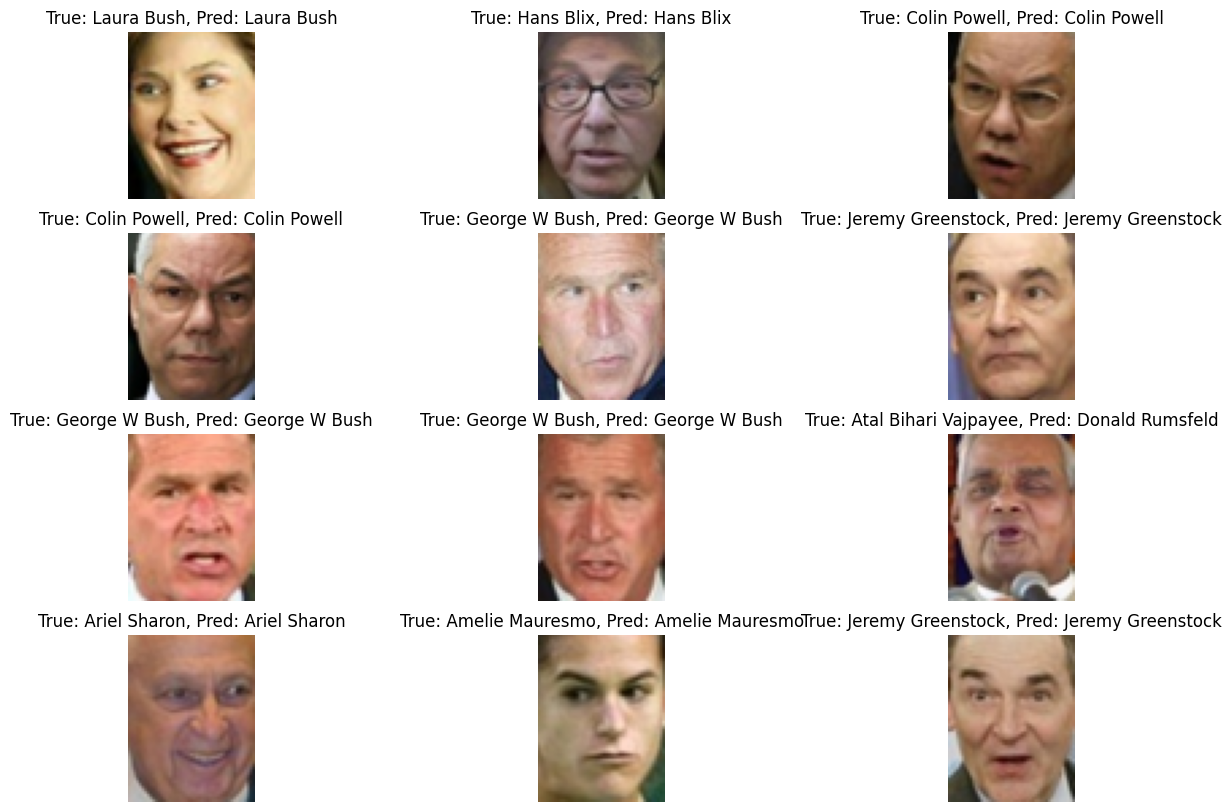

In [6]:
# Load and preprocess the LFW dataset
X_train, X_test, y_train, y_test, lfw_people = load_lfw_data()
X_train_gen, y_train_gen = augment_data(X_train, y_train, batch_size=32)
visualize_images(X_train_gen[10:20])
visualize_images(X_test[0:10])
train(X_train_gen, X_test, y_train_gen, y_test, lfw_people.target_names)
X_test, y_test, y_pred_classes = evaluate_model("../models/face_recognition_model.keras", X_test, y_test)
visualize_results(X_test, y_test, y_pred_classes, lfw_people.target_names)